# U-Net

> Neural net model

In [ ]:
#| default_exp models.unet

In [2]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [13]:
#| export
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch_lr_finder import LRFinder

from omegaconf import OmegaConf
from hydra.utils import instantiate

from matplotlib import pyplot as plt

from nimrod.models.conv import ConvBlock, DeconvBlock
from nimrod.models.resnet import ResBlock
from nimrod.models.core import Regressor, weight_init
from nimrod.utils import get_device, set_seed

from functools import partial

from typing import List, Optional, Callable, Any
import logging

In [3]:
#| export
logger = logging.getLogger(__name__)
set_seed()

Seed set to 42


## Tiny Unet

In [7]:
#| export

def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight, a=leaky)

def zero_weights(layer):
    with torch.no_grad():
        layer.weight.zero_()
        if hasattr(layer, 'bias') and hasattr(layer.bias, 'zero_'): layer.bias.zero_()

class TinyUnet(nn.Module):
    def __init__(
        self,
        n_features:List[int]=[3, 32, 64, 128, 256, 512, 1024], # Number of features in each layer
        activation=partial(nn.LeakyReLU, negative_slope=0.1), # Activation function
        normalization=nn.BatchNorm2d, # Normalization function
        pre_activation:bool=False, # use Resblock with pre-activation
        weight_initialization=False

    ):
        super().__init__()
        if len(n_features) < 3:
            raise ValueError("n_features must be at least 3")
        # first layer
        self.start = ResBlock(
            n_features[0],
            n_features[1],
            kernel_size=3,
            stride=1,
            activation=activation,
            normalization=normalization,
            pre_activation=pre_activation
            )

        self.encoder = nn.ModuleList()
        # encoder downsample receptive field
        down = partial(
            ResBlock,
            kernel_size=3, 
            stride=2,
            activation=activation,
            normalization=normalization,
            pre_activation=pre_activation
            )

        for i in range(1, len(n_features)-1):
            self.encoder.append(down(n_features[i], n_features[i+1]))

        # decoder upsampling receptive field
        up = partial(DeconvBlock, kernel_size=3, activation=activation, normalization=normalization)

        self.decoder = nn.ModuleList()
        for i in range(len(n_features)-1, 1, -1):
            self.decoder.append(up(n_features[i], n_features[i-1]))

        self.decoder += [down(n_features[1], n_features[0], stride=1)]

        self.end = ResBlock(
            n_features[0],
            n_features[0],
            kernel_size=3,
            stride=1,
            activation=nn.Identity,
            normalization=normalization,
            pre_activation=pre_activation
            )

        if weight_initialization:
            logger.info("Init conv & linear with kaiming")
            if isinstance(activation, partial):
                if activation.func == nn.LeakyReLU:
                    logger.info("LeakyRelu layers weight init")
                    wi = partial(weight_init, leaky=activation.keywords.get('negative_slope'))
                self.apply(wi)
            else:
                logger.info("ReLU layers weight init")
                self.apply(weight_init)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        layers = [] # store the output of each layer
        layers.append(x)
        x = self.start(x)
        for layer in self.encoder:
            layers.append(x)
            x = layer(x)
        n = len(layers)
        for i, layer in enumerate(self.decoder):
            if i != 0:
                x += layers[n-i]
            x = layer(x)
        return self.end(x+layers[0])
        

[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back to False as Batchnorm is used
[14:31:43] WARNING - setting conv bias back

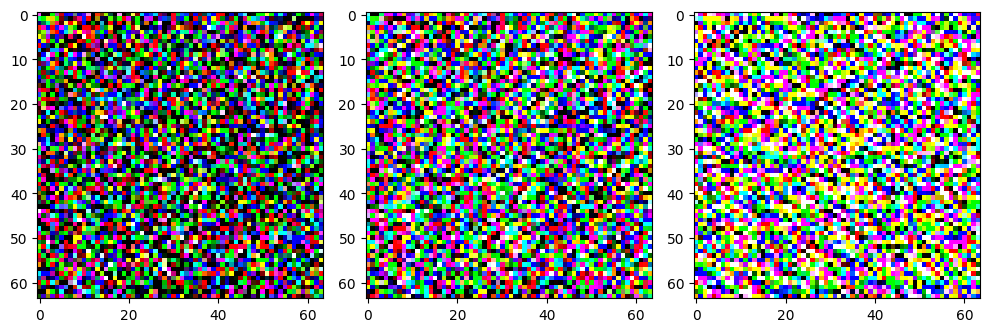

In [15]:
model = TinyUnet(n_features=[3, 16, 32], pre_activation=True)
model_init = TinyUnet(n_features=[3, 16, 32], pre_activation=True, weight_initialization=True)
x = torch.randn(1, 3, 64, 64)
model(x).shape
fig, ax = plt.subplots(1, 3, figsize=(10, 10), tight_layout=True)
ax[0].imshow(x.squeeze().permute(1,2,0), cmap='gray')
ax[1].imshow(model(x).squeeze().permute(1,2,0).detach(), cmap='gray')
ax[2].imshow(model_init(x).squeeze().permute(1,2,0).detach(), cmap='gray')
plt.show()

In [ ]:
#| export 

class TinyUnetX(Regressor):
    def __init__(
        self,
        nnet:TinyUnet, # super res autoencoder neural net
        optimizer: Callable[...,torch.optim.Optimizer], # optimizer partial
        scheduler: Optional[Callable[...,Any]]=None, # scheduler partial
    ):
        logger.info("SuperResAutoencoderX: init")
        super().__init__(
            nnet=nnet,
            optimizer=optimizer,
            scheduler=scheduler
            )
        self.nnet = nnet
        self.register_module('nnet', self.nnet)

In [ ]:
cfg = OmegaConf.load('../config/model/image/unetx.yaml')
model = instantiate(cfg.nnet)
x = torch.randn(1, 3, 64, 64)
model(x).shape


[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias back to False as Batchnorm is used
[17:43:42] WARNING - setting conv bias

torch.Size([1, 3, 64, 64])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()